In [1]:
import sys, os, re, copy
import dill as pickle # this serializes all the functions inside the quantification dict
import numpy as np
from scipy.optimize import newton, minimize, fsolve
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

## Fit and plot calibration curve for amino acid quantification
This program takes LCMS data from TraceFinder and generates calibration curves to quantify compounds using isotopically labelled internal standards. The input data is a dilution series of compounds with a constant concentration of isotopically internal standard associated for each compound. The peak area of each compound is normalized to its internal standard (this is the "response ratio") and a curve is fitted to this data. The curve fitting will choose the best curve among 1) linear fit, 2) power fit and 3) 2. degree polynomial fit. The chosen curve will be used for interpolation and two linear fits will be used for extrapolation; one below the lowest concentration in the calibration curve (forced to intersect 0) and one above the highest concentration in the calibration curve. The three curves are connected to a piecewise fit. The loss function used to chose and fit the curves are defined as the sum of the percentage deviation between true and predicted values.

In [2]:
def make_piece_wise_fit(amt_uM, rsp_ratio, amt_uM_range, rsp_ratio_range, df, debug=True):
    '''
    This function returns a piecewise function y = f(x)
    x = response ratio
    y = imputed sample concentration
    '''
    
    ### Here comes all functions related to curve fitting ###
    ### It is necessary to define these here so they get serialized during pickling ###
    # Loss functions:
    def loss_func_c1(t, y):
        return((np.abs(y - t) / t) * 100)
    def loss_func_l1(t, y):
        return(np.abs(y - t))  # l1
    def loss_func_l2(t, y):
        return((y - t)**2)     # l2

    # Linear fit intersecting 0:
    def lin_fit(x, beta):
        return(x*beta)
    def obj_lin_fit(loss_func, amt_uM, rsp_ratio, p):
        beta = p[0]
        y = lin_fit(rsp_ratio, beta)
        loss = sum(loss_func(amt_uM, y))
        return(loss)
    # Linear fit allowed to be offset 0:
    def lin_fit_off(x, alpha, beta):
        return(alpha + x*beta)
    def obj_lin_fit_off(loss_func, amt_uM, rsp_ratio, p):
        alpha = p[0]
        beta = p[1]
        y = lin_fit_off(rsp_ratio, alpha, beta)
        loss = sum(loss_func(amt_uM, y))
        return(loss)

    # Second degree polynomial fit intersecting 0:
    def pol2d_fit(x, beta, gamma):
        return(x**2*beta + x*gamma)
    def obj_pol2d_fit(loss_func, amt_uM, rsp_ratio, p):
        beta = p[0]
        gamma = p[1]
        y = pol2d_fit(rsp_ratio, beta, gamma)
        loss = sum(loss_func(amt_uM, y))
        return(loss)
    # Second degree polynomial fit allowed to be offset 0:
    def pol2d_fit_off(x, alpha, beta, gamma):
        return(alpha + x**2*beta + x*gamma)
    def obj_pol2d_fit_off(loss_func, amt_uM, rsp_ratio, p):
        alpha = p[0]
        beta = p[1]
        gamma = p[2]
        y = pol2d_fit_off(rsp_ratio, alpha, beta, gamma)
        loss = sum(loss_func(amt_uM, y))
        return(loss)

    # Power fit intersecting 0:
    def pow_fit(x, beta, gamma):
        return(beta*x**gamma)
    def obj_pow_fit(loss_func, amt_uM, rsp_ratio, p):
        beta = p[0]
        gamma = p[1]
        y = pow_fit(rsp_ratio, beta, gamma)
        loss = sum(loss_func(amt_uM, y))
        return(loss)
    # Power fit allowed to be offset 0:
    def pow_fit_off(x, alpha, beta, gamma):
        return(alpha + beta*x**gamma)
    def obj_pow_fit_off(loss_func, amt_uM, rsp_ratio, p):
        alpha = p[0]
        beta = p[1]
        gamma = p[2]
        y = pow_fit_off(rsp_ratio, alpha, beta, gamma)
        loss = sum(loss_func(amt_uM, y))
        return(loss)

    # Functions to pick the best interpolation, intersecting 0:
    def pick_best_fun(t, x):
        bnds = ((0, None),)
        def fun_lin(p): return(obj_lin_fit(loss_func_c1, t, x, p))
        p_lin = minimize(fun_lin, (1), method='L-BFGS-B', bounds=bnds)

        bnds = ((None, None), (0, None))
        def fun_pol2d(p): return(obj_pol2d_fit(loss_func_c1, t, x, p))
        p_pol2d = minimize(fun_pol2d, (1, 1), method='L-BFGS-B', bounds=bnds)

        bnds = ((0, None), (0, None))
        def fun_pow(p): return(obj_pow_fit(loss_func_c1, t, x, p))
        p_pow = minimize(fun_pow, (0.4, 1), method='L-BFGS-B', bounds=bnds)

        loss_list = [p_lin.fun, p_pol2d.fun, p_pow.fun]
        func_list = [lambda x: lin_fit(x, p_lin.x[0]), lambda x: pol2d_fit(x, p_pol2d.x[0], p_pol2d.x[1]), lambda x: pow_fit(x, p_pow.x[0], p_pow.x[1])]
        min_idx = loss_list.index(min(loss_list))
        best_fun = func_list[min_idx]
        return(best_fun)
    def pick_best_fun_l1(t, x):
        bnds = ((0, None),)
        def fun_lin(p): return(obj_lin_fit(loss_func_l1, t, x, p))
        p_lin = minimize(fun_lin, (1), method='L-BFGS-B', bounds=bnds)

        bnds = ((None, None), (0, None))
        def fun_pol2d(p): return(obj_pol2d_fit(loss_func_l1, t, x, p))
        p_pol2d = minimize(fun_pol2d, (1, 1), method='L-BFGS-B', bounds=bnds)

        bnds = ((0, None), (0, None))
        def fun_pow(p): return(obj_pow_fit(loss_func_l1, t, x, p))
        p_pow = minimize(fun_pow, (0.4, 1), method='L-BFGS-B', bounds=bnds)

        loss_list = [p_lin.fun, p_pol2d.fun, p_pow.fun]
        func_list = [lambda x: lin_fit(x, p_lin.x[0]), lambda x: pol2d_fit(x, p_pol2d.x[0], p_pol2d.x[1]), lambda x: pow_fit(x, p_pow.x[0], p_pow.x[1])]
        min_idx = loss_list.index(min(loss_list))
        best_fun = func_list[min_idx]
        return(best_fun)
    def pick_best_fun_l2(t, x):
        bnds = ((0, None),)
        def fun_lin(p): return(obj_lin_fit(loss_func_l2, t, x, p))
        p_lin = minimize(fun_lin, (1), method='L-BFGS-B', bounds=bnds)

        bnds = ((None, None), (0, None))
        def fun_pol2d(p): return(obj_pol2d_fit(loss_func_l2, t, x, p))
        p_pol2d = minimize(fun_pol2d, (1, 1), method='L-BFGS-B', bounds=bnds)

        bnds = ((0, None), (0, None))
        def fun_pow(p): return(obj_pow_fit(loss_func_l2, t, x, p))
        p_pow = minimize(fun_pow, (0.4, 1), method='L-BFGS-B', bounds=bnds)

        loss_list = [p_lin.fun, p_pol2d.fun, p_pow.fun]
        func_list = [lambda x: lin_fit(x, p_lin.x[0]), lambda x: pol2d_fit(x, p_pol2d.x[0], p_pol2d.x[1]), lambda x: pow_fit(x, p_pow.x[0], p_pow.x[1])]
        min_idx = loss_list.index(min(loss_list))
        best_fun = func_list[min_idx]
        return(best_fun)

    # Functions to pick the best interpolation allowed to be offset 0:
    def pick_best_fun_off(t, x):
        bnds = ((None, None), (0, None))
        def fun_lin(p): return(obj_lin_fit_off(loss_func_c1, t, x, p))
        p_lin1 = minimize(fun_lin, (0, 1), method='L-BFGS-B', bounds=bnds)

        bnds = ((None, None), (0, None))
        def fun_lin(p): return(obj_lin_fit_off(loss_func_c1, t, x, p))
        p_lin2 = minimize(fun_lin, (0, 1), method='SLSQP', bounds=bnds)

        bnds = ((None, None), (None, None), (0, None))
        def fun_pol2d(p): return(obj_pol2d_fit_off(loss_func_c1, t, x, p))
        p_pol2d1 = minimize(fun_pol2d, (0, 1, 1), method='L-BFGS-B', bounds=bnds)

        bnds = ((None, None), (None, None), (0, None))
        def fun_pol2d(p): return(obj_pol2d_fit_off(loss_func_c1, t, x, p))
        p_pol2d2 = minimize(fun_pol2d, (0, 1, 1), method='SLSQP', bounds=bnds)

        bnds = ((None, None), (0, None), (0, None))
        def fun_pow(p): return(obj_pow_fit_off(loss_func_c1, t, x, p))
        p_pow1 = minimize(fun_pow, (0, 0.4, 1), method='L-BFGS-B', bounds=bnds)

        bnds = ((None, None), (0, None), (0, None))
        def fun_pow(p): return(obj_pow_fit_off(loss_func_c1, t, x, p))
        p_pow2 = minimize(fun_pow, (0, 0.4, 1), method='SLSQP', bounds=bnds)

        loss_list = [p_lin1.fun, p_lin2.fun, p_pol2d1.fun, p_pol2d2.fun, p_pow1.fun, p_pow2.fun]
        func_list = [lambda x: lin_fit_off(x, p_lin1.x[0], p_lin1.x[1]), lambda x: lin_fit_off(x, p_lin2.x[0], p_lin2.x[1]), lambda x: pol2d_fit_off(x, p_pol2d1.x[0], p_pol2d1.x[1], p_pol2d1.x[2]), lambda x: pol2d_fit_off(x, p_pol2d2.x[0], p_pol2d2.x[1], p_pol2d2.x[2]), lambda x: pow_fit_off(x, p_pow1.x[0], p_pow1.x[1], p_pow1.x[2]), lambda x: pow_fit_off(x, p_pow2.x[0], p_pow2.x[1], p_pow2.x[2])]
        min_idx = loss_list.index(min(loss_list))
        best_fun = func_list[min_idx]
        return(best_fun)
    def pick_best_fun_off_l1(t, x):
        bnds = ((None, None), (0, None))
        def fun_lin(p): return(obj_lin_fit_off(loss_func_l1, t, x, p))
        p_lin = minimize(fun_lin, (0, 1), method='L-BFGS-B', bounds=bnds)

        bnds = ((None, None), (None, None), (0, None))
        def fun_pol2d(p): return(obj_pol2d_fit_off(loss_func_l1, t, x, p))
        p_pol2d = minimize(fun_pol2d, (0, 1, 1), method='L-BFGS-B', bounds=bnds)

        bnds = ((None, None), (0, None), (0, None))
        def fun_pow(p): return(obj_pow_fit_off(loss_func_l1, t, x, p))
        p_pow = minimize(fun_pow, (0, 0.4, 1), method='L-BFGS-B', bounds=bnds)

        loss_list = [p_lin.fun, p_pol2d.fun, p_pow.fun]
        func_list = [lambda x: lin_fit_off(x, p_lin.x[0], p_lin.x[1]), lambda x: pol2d_fit_off(x, p_pol2d.x[0], p_pol2d.x[1], p_pol2d.x[2]), lambda x: pow_fit_off(x, p_pow.x[0], p_pow.x[1], p_pow.x[2])]
        min_idx = loss_list.index(min(loss_list))
        best_fun = func_list[min_idx]
        return(best_fun)

    # Function to pick the best extrapolation:
    def pick_lin_fun(t, x, off):
        if off is True:
            bnds = ((None, None), (0, None))
            def fun_lin(p): return(obj_lin_fit_off(loss_func_l1, t, x, p))
            p_lin = minimize(fun_lin, (0, 1), method='L-BFGS-B', bounds=bnds)
            return(lambda x: lin_fit_off(x, p_lin.x[0], p_lin.x[1]))
        elif off is False:
            bnds = ((0, None),)
            def fun_lin(p): return(obj_lin_fit(loss_func_l1, t, x, p))
            p_lin = minimize(fun_lin, (1), method='L-BFGS-B', bounds=bnds)
            return(lambda x: lin_fit(x, p_lin.x[0]))
        else:
            raise Exception('Unrecognized off: {}'.format(off))


    ### Now creating the quant function ###    
    piece_wise_fit = dict()
    smo_frac = 0.4 # linear smoothening, fraction +/- response ratio

    ### Extrapolate above highest response ratio ###
    ub = rsp_ratio_range[0]
    lb = rsp_ratio_range[1] + smo_frac*rsp_ratio_range[1]
    key_extra_up = (ub, lb)

    mask = (amt_uM == amt_uM_range[1]) | (amt_uM == amt_uM_range[2]) | (amt_uM == amt_uM_range[3]) | (amt_uM == amt_uM_range[4]) | (amt_uM == amt_uM_range[5])
    amt_uM_tmp = amt_uM[mask]
    rsp_ratio_tmp = rsp_ratio[mask]

    # Restrict the extrapolation to linear fit:
    # piece_wise_fit[key_extra_up] = pick_best_fun(amt_uM_tmp, rsp_ratio_tmp)
    piece_wise_fit[key_extra_up] = pick_lin_fun(amt_uM_tmp, rsp_ratio_tmp, True)

    ### Interpolate between highest and lowest response ratio ###
    ub = rsp_ratio_range[1] - smo_frac*rsp_ratio_range[1]
    lb = rsp_ratio_range[len(amt_uM_range)-2] + smo_frac*rsp_ratio_range[len(amt_uM_range)-2]
    key_intra = (ub, lb)
    piece_wise_fit[key_intra] = pick_best_fun_off(amt_uM, rsp_ratio)

    ### Smoothen between the upper extrapolation and the intrapolation ###
    ub = rsp_ratio_range[1] + smo_frac*rsp_ratio_range[1]
    lb = rsp_ratio_range[1] - smo_frac*rsp_ratio_range[1]
    key_between_intra_up = (ub, lb)
    
    y_upper = piece_wise_fit[key_extra_up](ub)
    y_lower = piece_wise_fit[key_intra](lb)

    beta_upper = (y_upper - y_lower) / (ub - lb)
    if beta_upper < 0:
        print('Upper smoothening gave negative slope!!! Maybe adjust smo_frac.')
    alpha_upper = y_upper - beta_upper*ub
    piece_wise_fit[key_between_intra_up] = lambda x: alpha_upper + beta_upper*x

    ### Extrapolate between 0 and lowest response ratio ###
    ub = rsp_ratio_range[len(amt_uM_range)-2] - smo_frac*rsp_ratio_range[len(amt_uM_range)-2]
    lb = rsp_ratio_range[len(amt_uM_range)-1]
    key_extra_low = (ub, lb)

    i = len(amt_uM_range)-2
    # Extrapolate from the 5 lowest concentrations:
    mask = (amt_uM == amt_uM_range[i-3]) | (amt_uM == amt_uM_range[i-2]) | (amt_uM == amt_uM_range[i-1]) | (amt_uM == amt_uM_range[i]) | (amt_uM == amt_uM_range[i+1])
    amt_uM_tmp = amt_uM[mask]
    rsp_ratio_tmp = rsp_ratio[mask]
    piece_wise_fit[key_extra_low] = pick_best_fun_l1(amt_uM_tmp, rsp_ratio_tmp)
    #piece_wise_fit[key_extra_low] = pick_lin_fun(amt_uM_tmp, rsp_ratio_tmp, False)

    ### Smoothen between the lower extrapolation and the intrapolation ###
    ub = rsp_ratio_range[len(amt_uM_range)-2] + smo_frac*rsp_ratio_range[len(amt_uM_range)-2]
    lb = rsp_ratio_range[len(amt_uM_range)-2] - smo_frac*rsp_ratio_range[len(amt_uM_range)-2]
    key_between_intra_low = (ub, lb)
    
    y_upper = piece_wise_fit[key_intra](ub)
    y_lower = piece_wise_fit[key_extra_low](lb)

    beta_lower = (y_upper - y_lower) / (ub - lb)
    if beta_lower < 0:
        print('Lower smoothening gave negative slope!!! Maybe adjust smo_frac.')
    alpha_lower = y_upper - beta_lower*ub
    piece_wise_fit[key_between_intra_low] = lambda x: alpha_lower + beta_lower*x

    if debug is True:
        plot_cal_curve(df, piece_wise_fit)

    return(piece_wise_fit)

In [3]:
def impute_conc(piece_wise_fit_metab, response_ratio):
    '''
    This function imputes the concentration from a response ratio.
    '''
    response_ratio_range = np.array(list(piece_wise_fit_metab.keys()))
    mask_range = [response_ratio >= min_v and response_ratio <= max_v for max_v, min_v in response_ratio_range]
    k = tuple(response_ratio_range[mask_range][0])
    return(piece_wise_fit_metab[k](response_ratio))

In [4]:
def plot_cal_curve(df, piece_wise_fit_metab):
    '''
    Plot for debugging.
    '''
    plt.figure(figsize=(5, 4))
    #plt.scatter(rr_mes_metab, imp_conc_mes_metab, color='red', marker='x')
    ax = sns.scatterplot(x="Response Ratio", y="Theoretical Amt", data=df)
    ax.set(xscale="log", yscale="log")
    ax.set_title('{}'.format(metab))
    for k in piece_wise_fit_metab.keys():
        ub, lb = k
        if ub == float('inf'):
            ub = 3*lb
        if lb == 0:
            lb = ub * 1e-1
        x = np.linspace(lb, ub, 1000)
        y = piece_wise_fit_metab[k](x)
        plt.plot(x, y, linewidth=1, color='black')

In [5]:
def plot_cal_piece_wise_fit(metab, df, piece_wise_fit_metab, save=False, linscale=False):
    '''
    Plot the calibration curve data with the piece wise fit.
    '''
    if linscale: # Plot measured points on linear scale
        plt.figure(figsize=(7, 6))
        ax = sns.scatterplot(rr_mes_metab, imp_conc_mes_metab, color='red', marker='x')
        ax.set_title('Lin. mes. {}'.format(metab))
        plt.show()
    else: # Plot both measured and calibration points on log-log scale
        fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.4))

        g1 = sns.scatterplot(ax=ax1, x="Response Ratio", y="Theoretical Amt", data=df)
        g1.set(xscale="log", yscale="log", ylabel='Concentration (μM)')
        g1.set_title('{}'.format(metab[0:-4]))
        g1.grid(True)

        for line_idx, k in enumerate(piece_wise_fit_metab.keys()):
            ub, lb = k
            if ub == float('inf'): # Extrapolation (over)
                ub = 3*lb
            if lb == 0: # Extrapolation (under)
                lb = ub * 0.5
            x = np.logspace(np.log10(lb), np.log10(ub), 1000)
            y = piece_wise_fit_metab[k](x)
            ax1.plot(x, y, linewidth=1, color='black', linestyle='--')
            # ax1.plot(x, y, linewidth=2, color=palette[line_idx], linestyle='--')

        fig.tight_layout()
        if save:
            return(fig)
        else:
            fig.show()

In [16]:
### Read calibration data:
### Replace all N/F with 0 before start ###
# input_fnam = 'cal-curve_LCMS-data_runs/AA_quant_april_22.xlsx'
# input_fnam = 'cal-curve_LCMS-data_runs/AA_quant_aug21.xlsx'
input_fnam = 'cal-curve_LCMS-data_runs/AA_quant_oct20.xlsx'
esheet_dict_cal = pd.read_excel(input_fnam, sheet_name=None)
metab_dict_cal = dict()
metab_names_cal = list()
for k in esheet_dict_cal.keys():
    if 'U-13C' not in k:
        metab_names_cal.append(k)
        # Remove non calibration standards and zero peaks:
        df_tmp = copy.deepcopy(esheet_dict_cal[k])
        df_tmp['Response Ratio'] = df_tmp['Area'].values / df_tmp['ISTD Response'].values
        mask_cal = df_tmp['Theoretical Amt'].values > 0
        metab_dict_cal[k] = df_tmp.loc[mask_cal]

/var/folders/mj/73ldg06x6kdgxkg6t725sxc00000gn/T/ipykernel_58797/3490248903.py:14: RuntimeWarning: invalid value encountered in divide
  df_tmp['Response Ratio'] = df_tmp['Area'].values / df_tmp['ISTD Response'].values
/var/folders/mj/73ldg06x6kdgxkg6t725sxc00000gn/T/ipykernel_58797/3490248903.py:14: RuntimeWarning: divide by zero encountered in divide
  df_tmp['Response Ratio'] = df_tmp['Area'].values / df_tmp['ISTD Response'].values


In [17]:
### Fit calibration curve ###
piece_wise_fit = dict()
for metab in metab_names_cal:
    amt_uM = metab_dict_cal[metab]['Theoretical Amt'].values
    rsp_ratio = metab_dict_cal[metab]['Response Ratio'].values
    df = metab_dict_cal[metab]
    # Extract the fitting range:
    amt_uM_range = sorted(np.unique(amt_uM), reverse=True)
    rsp_ratio_range = [np.average(rsp_ratio[(amt_uM == r)]) for r in amt_uM_range]
    amt_uM_range.append(0)
    amt_uM_range.insert(0, float('inf'))
    rsp_ratio_range.append(0)
    rsp_ratio_range.insert(0, float('inf'))
    # Fit the data:
    piece_wise_fit[metab] = make_piece_wise_fit(amt_uM, rsp_ratio, amt_uM_range, rsp_ratio_range, df, debug=False)

/var/folders/mj/73ldg06x6kdgxkg6t725sxc00000gn/T/ipykernel_58797/2984365574.py:67: RuntimeWarning: overflow encountered in power
  return(alpha + beta*x**gamma)
/Users/krdav/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/mj/73ldg06x6kdgxkg6t725sxc00000gn/T/ipykernel_58797/2984365574.py:67: RuntimeWarning: overflow encountered in multiply
  return(alpha + beta*x**gamma)
/var/folders/mj/73ldg06x6kdgxkg6t725sxc00000gn/T/ipykernel_58797/2984365574.py:256: RuntimeWarning: divide by zero encountered in scalar divide
  beta_lower = (y_upper - y_lower) / (ub - lb)
/var/folders/mj/73ldg06x6kdgxkg6t725sxc00000gn/T/ipykernel_58797/2984365574.py:259: RuntimeWarning: invalid value encountered in scalar multiply
  alpha_lower = y_upper - beta_lower*ub


In [18]:
### Plot measured values on calibration curve ###
# output_ext = 'april_22'
# output_ext = 'aug_21'
output_ext = 'oct_20'
fnam_out = 'calibration_curves_{}.pdf'.format(output_ext)
save_pdf = True
if save_pdf:
    pdf = matplotlib.backends.backend_pdf.PdfPages(fnam_out)
    for metab in metab_names_cal:
        fig = plot_cal_piece_wise_fit(metab, metab_dict_cal[metab], piece_wise_fit[metab], save=save_pdf)
        pdf.savefig(fig)
        plt.close(fig)
    pdf.close()
else:
    for metab in metab_names_cal:
        plot_cal_piece_wise_fit(metab, metab_dict_cal[metab], piece_wise_fit[metab], save=save_pdf)

/var/folders/mj/73ldg06x6kdgxkg6t725sxc00000gn/T/ipykernel_58797/3289012157.py:24: RuntimeWarning: divide by zero encountered in log10
  x = np.logspace(np.log10(lb), np.log10(ub), 1000)
/Users/krdav/anaconda3/lib/python3.11/site-packages/numpy/core/function_base.py:138: RuntimeWarning: invalid value encountered in scalar subtract
  delta = stop - start
/var/folders/mj/73ldg06x6kdgxkg6t725sxc00000gn/T/ipykernel_58797/2984365574.py:260: RuntimeWarning: invalid value encountered in multiply
  piece_wise_fit[key_between_intra_low] = lambda x: alpha_lower + beta_lower*x


In [19]:
# Pickle all the relevant compounds:
dict_pickle_fnam = 'AA-quant_{}.pickle'.format(output_ext)
all_comp = list(piece_wise_fit.keys())
not_quant = ['Histidine pos']
# not_quant = ['Histidine pos', 'Cystine pos', 'Glycine neg']
for metab in not_quant:
    if metab in piece_wise_fit:
        del piece_wise_fit[metab]

with open(dict_pickle_fnam, 'wb') as handle:
    pickle.dump(piece_wise_fit, handle)

### Amino acid standard, deviation from the mean
Here, 10 tubes of amino acid standard was randomly picked, reconstituted and run to assess the reproducibility of the peak area.
If high, this would reveal problems with pipetting, breakdown (e.g. for Asn/Gln), loading etc.

In [10]:
### Read internal standard data:
input_fnam = 'cal-curve_LCMS-data_runs/CAA_samples_03-31-22.xlsx'
esheet_dict_cal = pd.read_excel(input_fnam, sheet_name=None)
metab_dict_cal = dict()
metab_names_cal = list()
for k in esheet_dict_cal.keys():
    metab_names_cal.append(k)
    metab_dict_cal[k] = copy.deepcopy(esheet_dict_cal[k])

# Find a store the deviation from the mean:
df = copy.deepcopy(metab_dict_cal[metab_names_cal[0]]).drop(['Compound', 'RT', 'Formula', 'ISTD Response', 'Response Ratio', 'Flag Details', 'Type', 'Theoretical Amt', 'Sample ID', 'Area'], axis=1)
for nam in metab_names_cal:
    area = metab_dict_cal[nam]['Area'].values
    mean = metab_dict_cal[nam]['Area'].values.mean()
    area_dev = (area - mean) / mean * 100
    df[nam] = area_dev
df['Filename'] = [v[-4:] for v in df['Filename'].values]
# Flatten for plotting:
df_flat = pd.melt(df, id_vars=['Filename']).rename(columns={'variable': 'Amino acid', 'value': 'Area'})

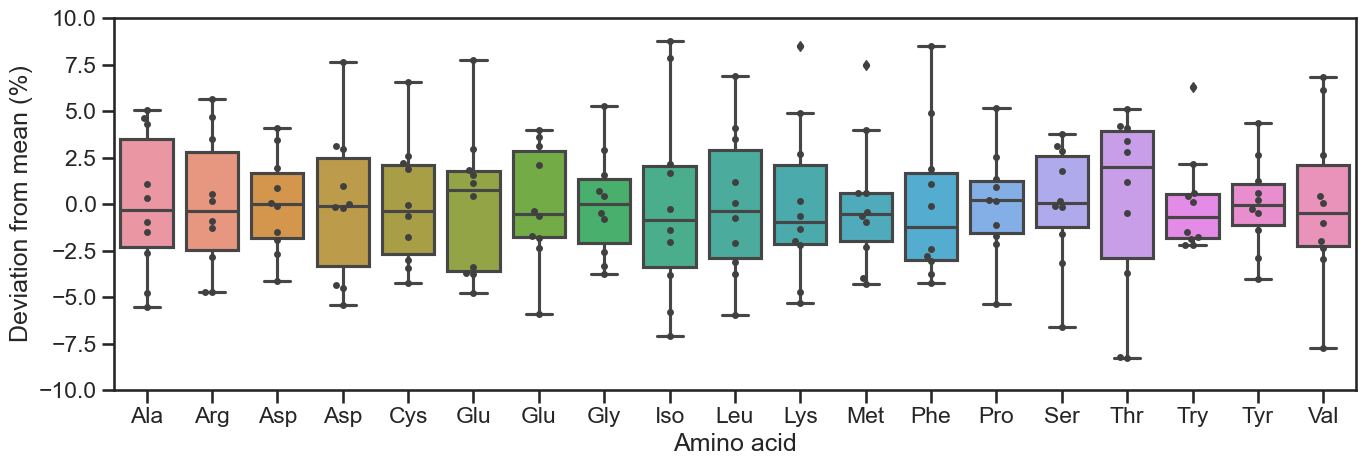

In [11]:
# Plot the deviation:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 5))
g1 = sns.boxplot(x='Amino acid', y='Area', data=df_flat, ax=ax1)
g1 = sns.swarmplot(x='Amino acid', y='Area', data=df_flat, ax=ax1, color=".25")
g1.set_xticklabels([t.get_text()[0:3] for t in g1.get_xticklabels()], rotation=0);
g1.set_ylabel('Deviation from mean (%)');
g1.set_ylim([-10, 10]);
fig.tight_layout()
fig.savefig('CAA-samples_deviation_03-31-22.pdf');